In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from geopy import distance
from sklearn.neighbors import KNeighborsClassifier

In [3]:
pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 49.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_csv('/kaggle/input/yourcabs-score-cancellation/YourCabs_training.csv')
df.head(10)

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1.0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1.0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1.0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1.0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1.0
5,132518,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/2013 22:30,NaN,0,0,1/1/2013 8:01,13.028530,77.546250,12.869805,77.653211,0,1.0
6,132519,22172,12,NaN,1,571.0,NaN,15.0,108.0,1/1/2013 9:45,41275.40625,0,0,1/1/2013 9:21,12.951850,77.696420,NaN,NaN,0,1.0
7,132520,22181,12,NaN,2,1192.0,832.0,NaN,NaN,1/1/2013 11:00,NaN,0,0,1/1/2013 9:39,12.976770,77.572700,12.880190,77.645580,0,1.0
8,132521,22182,65,2.0,3,448.0,NaN,NaN,NaN,1/1/2013 16:00,NaN,0,0,1/1/2013 9:44,12.927320,77.635750,NaN,NaN,0,1.0
9,132522,22184,12,NaN,2,516.0,376.0,NaN,NaN,1/1/2013 11:00,NaN,0,0,1/1/2013 9:49,13.005600,77.657990,12.902450,77.660810,0,1.0


In [5]:
df.shape
#There are 43431 rows and 20 columns

(43431, 20)

In [6]:
#Chek data information: total number of rows, columns, data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   43431 non-null  int64  
 1   user_id              43431 non-null  int64  
 2   vehicle_model_id     43431 non-null  int64  
 3   package_id           7550 non-null   float64
 4   travel_type_id       43431 non-null  int64  
 5   from_area_id         43343 non-null  float64
 6   to_area_id           34293 non-null  float64
 7   from_city_id         16345 non-null  float64
 8   to_city_id           1588 non-null   float64
 9   from_date            43431 non-null  object 
 10  to_date              25541 non-null  float64
 11  online_booking       43431 non-null  int64  
 12  mobile_site_booking  43431 non-null  int64  
 13  booking_created      43431 non-null  object 
 14  from_lat             43338 non-null  float64
 15  from_long            43338 non-null 

In [7]:
df.dtypes.value_counts()

float64    11
int64       7
object      2
dtype: int64

There are 2 object data types are date/time columns. We will convert them into right data types later on

# **DATA PRE-PROCESSING**

**Columns name**

In [8]:
#Rename columns
column_mapping = {
    'id': 'id',
    'user_id': 'user_id',
    'vehicle_model_id': 'vehicle_model_type',
    'package_id': 'package_type',
    'travel_type_id': 'travel_type',
    'from_area_id': 'from_area',
    'to_area_id': 'to_area',
    'from_city_id':'from_city_id',
    'to_city_id':'to_city_id',
    'from_date': 'from_date',
    'to_date':'to_date',
    'online_booking':'desktop_booking',
    'mobile_site_booking':'mobile_booking',
    'booking_created': 'booking_dated',
    'from_lat': 'from_lat',
    'from_long': 'from_long',
    'to_lat': 'to_lat',
    'to_long': 'to_long',
    'Car_Cancellation': 'Car_Cancellation',
    'Cost_of_error': 'Cost_of_error'
}
df = df.rename(columns =column_mapping)
    
#Check updated columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  43431 non-null  int64  
 1   user_id             43431 non-null  int64  
 2   vehicle_model_type  43431 non-null  int64  
 3   package_type        7550 non-null   float64
 4   travel_type         43431 non-null  int64  
 5   from_area           43343 non-null  float64
 6   to_area             34293 non-null  float64
 7   from_city_id        16345 non-null  float64
 8   to_city_id          1588 non-null   float64
 9   from_date           43431 non-null  object 
 10  to_date             25541 non-null  float64
 11  desktop_booking     43431 non-null  int64  
 12  mobile_booking      43431 non-null  int64  
 13  booking_dated       43431 non-null  object 
 14  from_lat            43338 non-null  float64
 15  from_long           43338 non-null  float64
 16  to_l

In [9]:
#Check missing values
df.isnull().mean()

id                    0.000000
user_id               0.000000
vehicle_model_type    0.000000
package_type          0.826161
travel_type           0.000000
from_area             0.002026
to_area               0.210403
from_city_id          0.623656
to_city_id            0.963436
from_date             0.000000
to_date               0.411918
desktop_booking       0.000000
mobile_booking        0.000000
booking_dated         0.000000
from_lat              0.002141
from_long             0.002141
to_lat                0.210403
to_long               0.210403
Car_Cancellation      0.000000
Cost_of_error         0.000000
dtype: float64

We can see from above results, 'package_type', 'from_area', 'to_area', 'from_city_id', 'to_city_id', 'to_date','from_lat', 'from_long','to_lat', 'to_long' have non-values

In [10]:
#Drop columns before handling with missing values
columns_to_drop = ['id','user_id','package_type','to_area','from_city_id','to_city_id','to_date']
df.drop(columns_to_drop, axis=1, inplace=True)
df.columns

Index(['vehicle_model_type', 'travel_type', 'from_area', 'from_date',
       'desktop_booking', 'mobile_booking', 'booking_dated', 'from_lat',
       'from_long', 'to_lat', 'to_long', 'Car_Cancellation', 'Cost_of_error'],
      dtype='object')

We already deleted some columns have more than 80% of missing values and unneeded columns

**Handling with missing values**

In [11]:
df.isnull().sum()

vehicle_model_type       0
travel_type              0
from_area               88
from_date                0
desktop_booking          0
mobile_booking           0
booking_dated            0
from_lat                93
from_long               93
to_lat                9138
to_long               9138
Car_Cancellation         0
Cost_of_error            0
dtype: int64

In [12]:
#Drop non-values in 'from_area', 'from_lat', 'from_long' columns because of small percenatge
#Fill non-values in 'to_lat', 'to_long' with mean values with numeric data
df.dropna(subset=['from_area','from_lat','from_long'], inplace=True)
df['to_lat'].fillna(df['to_lat'].mean(),inplace=True)
df['to_long'].fillna(df['to_long'].mean(),inplace=True)

In [13]:
#Confirm the changes
print("Missing values")
df.isnull().sum()

Missing values


vehicle_model_type    0
travel_type           0
from_area             0
from_date             0
desktop_booking       0
mobile_booking        0
booking_dated         0
from_lat              0
from_long             0
to_lat                0
to_long               0
Car_Cancellation      0
Cost_of_error         0
dtype: int64

**Data Transformation**

In [14]:
#Convert date columns into datetime format
df['from_date_dt'] = pd.to_datetime(df['from_date']).dt.strftime('%m/%d/%Y')
df['from_date_time'] = pd.to_datetime(df['from_date']).dt.strftime('%H:%M')
df['booking_created_dt'] = pd.to_datetime(df['booking_dated']).dt.strftime('%m/%d/%Y')
df['booking_created_time']=pd.to_datetime(df['booking_dated']).dt.strftime('%H:%M')

In [15]:
#Extract day month components from 'from_date_dt'
df['from_date_day_name'] = pd.to_datetime(df['from_date_dt']).dt.day_name()
df['from_date_day_num'] = pd.to_datetime(df['from_date_dt']).dt.day_of_week #The day of the week with Monday=0, Sunday=6.
df['from_date_month_name'] = pd.to_datetime(df['from_date_dt']).dt.month_name()
df['from_date_month_num'] = pd.to_datetime(df['from_date_dt']).dt.month
df[['from_date_dt','from_date_day_name', 'from_date_day_num','from_date_month_name','from_date_month_num']].head(10)

,from_date_dt,from_date_day_name,from_date_day_num,from_date_month_name,from_date_month_num
0,01/01/2013,Tuesday,1,January,1
1,01/01/2013,Tuesday,1,January,1
2,01/01/2013,Tuesday,1,January,1
3,01/01/2013,Tuesday,1,January,1
4,01/01/2013,Tuesday,1,January,1
5,01/01/2013,Tuesday,1,January,1
6,01/01/2013,Tuesday,1,January,1
7,01/01/2013,Tuesday,1,January,1
8,01/01/2013,Tuesday,1,January,1
9,01/01/2013,Tuesday,1,January,1


In [16]:
#Extract day month components from 'from_date_dt'
df['booking_created_day_name'] = pd.to_datetime(df['booking_created_dt']).dt.day_name()
df['booking_created_day_num'] = pd.to_datetime(df['booking_created_dt']).dt.day_of_week #The day of the week with Monday=0, Sunday=6.
df['booking_created_month_name'] = pd.to_datetime(df['booking_created_dt']).dt.month_name()
df['booking_created_month_num'] = pd.to_datetime(df['booking_created_dt']).dt.month
df[['booking_created_dt','booking_created_day_name', 'booking_created_day_num','booking_created_month_name','booking_created_month_num']].head(10)

,booking_created_dt,booking_created_day_name,booking_created_day_num,booking_created_month_name,booking_created_month_num
0,01/01/2013,Tuesday,1,January,1
1,01/01/2013,Tuesday,1,January,1
2,01/01/2013,Tuesday,1,January,1
3,01/01/2013,Tuesday,1,January,1
4,01/01/2013,Tuesday,1,January,1
5,01/01/2013,Tuesday,1,January,1
6,01/01/2013,Tuesday,1,January,1
7,01/01/2013,Tuesday,1,January,1
8,01/01/2013,Tuesday,1,January,1
9,01/01/2013,Tuesday,1,January,1


In [17]:
#Create Weekend Flag
df['from_date:is_weekend'] = np.where(df['from_date_day_num'].isin([5,6]), 1,0)
df['booking_created:is_weekend'] = np.where(df['booking_created_day_num'].isin([5,6]), 1,0)

df[['from_date_dt','from_date_day_num','from_date:is_weekend']].head()
df[['booking_created_dt','booking_created_day_num','booking_created:is_weekend']].head()

,booking_created_dt,booking_created_day_num,booking_created:is_weekend
0,01/01/2013,1,0
1,01/01/2013,1,0
2,01/01/2013,1,0
3,01/01/2013,1,0
4,01/01/2013,1,0


In [18]:
#Create Day Part Flag
def day_part(hour):
    if hour in [4,5]:
        return "dawn"
    elif hour in [6,7]:
        return "early morning"
    elif hour in [8,9,10]:
        return "late morning"
    elif hour in [11,12,13]:
        return "noon"
    elif hour in [14,15,16]:
        return "afternoon"
    elif hour in [17, 18,19]:
        return "evening"
    elif hour in [20, 21, 22]:
        return "night"
    elif hour in [23,24,1,2,3]:
        return "midnight"
    
    
# utilize it along with apply method in 'from_date_time'
df['from_date:hour'] = pd.to_datetime(df['from_date_time']).dt.hour
df['from_date:day_part'] = df['from_date:hour'].apply(day_part)
df.head()

,vehicle_model_type,travel_type,from_area,from_date,desktop_booking,mobile_booking,booking_dated,from_lat,from_long,to_lat,...,from_date_month_name,from_date_month_num,booking_created_day_name,booking_created_day_num,booking_created_month_name,booking_created_month_num,from_date:is_weekend,booking_created:is_weekend,from_date:hour,from_date:day_part
0,28,2,83.0,1/1/2013 2:00,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,...,January,1,Tuesday,1,January,1,0,0,2,midnight
1,12,2,1010.0,1/1/2013 9:00,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,...,January,1,Tuesday,1,January,1,0,0,9,late morning
2,12,2,1301.0,1/1/2013 3:30,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,...,January,1,Tuesday,1,January,1,0,0,3,midnight
3,12,2,768.0,1/1/2013 5:45,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,...,January,1,Tuesday,1,January,1,0,0,5,dawn
4,12,2,1365.0,1/1/2013 9:00,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,...,January,1,Tuesday,1,January,1,0,0,9,late morning


In [19]:
    
# utilize it along with apply method in 'from_date_time'
df['booking_created:hour'] = pd.to_datetime(df['booking_created_time']).dt.hour
df['booking_created:day_part'] = df['booking_created:hour'].apply(day_part)
df.head()

,vehicle_model_type,travel_type,from_area,from_date,desktop_booking,mobile_booking,booking_dated,from_lat,from_long,to_lat,...,booking_created_day_name,booking_created_day_num,booking_created_month_name,booking_created_month_num,from_date:is_weekend,booking_created:is_weekend,from_date:hour,from_date:day_part,booking_created:hour,booking_created:day_part
0,28,2,83.0,1/1/2013 2:00,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,...,Tuesday,1,January,1,0,0,2,midnight,1,midnight
1,12,2,1010.0,1/1/2013 9:00,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,...,Tuesday,1,January,1,0,0,9,late morning,2,midnight
2,12,2,1301.0,1/1/2013 3:30,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,...,Tuesday,1,January,1,0,0,3,midnight,3,midnight
3,12,2,768.0,1/1/2013 5:45,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,...,Tuesday,1,January,1,0,0,5,dawn,4,dawn
4,12,2,1365.0,1/1/2013 9:00,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,...,Tuesday,1,January,1,0,0,9,late morning,7,early morning


In [20]:
df['time_diff'] = (pd.to_datetime(df['from_date']) - pd.to_datetime(df['booking_dated'])).astype('timedelta64[m]')
df[['from_date', 'booking_dated', 'time_diff']].head()

,from_date,booking_dated,time_diff
0,1/1/2013 2:00,1/1/2013 1:39,21.0
1,1/1/2013 9:00,1/1/2013 2:25,395.0
2,1/1/2013 3:30,1/1/2013 3:08,22.0
3,1/1/2013 5:45,1/1/2013 4:39,66.0
4,1/1/2013 9:00,1/1/2013 7:53,67.0


In [21]:
df = df.drop(['from_date','booking_dated','from_date_dt','from_date_time','booking_created_dt','booking_created_time'],axis=1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43338 entries, 0 to 43430
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   vehicle_model_type          43338 non-null  int64  
 1   travel_type                 43338 non-null  int64  
 2   from_area                   43338 non-null  float64
 3   desktop_booking             43338 non-null  int64  
 4   mobile_booking              43338 non-null  int64  
 5   from_lat                    43338 non-null  float64
 6   from_long                   43338 non-null  float64
 7   to_lat                      43338 non-null  float64
 8   to_long                     43338 non-null  float64
 9   Car_Cancellation            43338 non-null  int64  
 10  Cost_of_error               43338 non-null  float64
 11  from_date_day_name          43338 non-null  object 
 12  from_date_day_num           43338 non-null  int64  
 13  from_date_month_name        433

# Exploration Data Analysis

In [23]:
df.describe()

,vehicle_model_type,travel_type,from_area,desktop_booking,mobile_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error,from_date_day_num,from_date_month_num,booking_created_day_num,booking_created_month_num,from_date:is_weekend,booking_created:is_weekend,from_date:hour,booking_created:hour,time_diff
count,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000,43338.000000
mean,25.684872,2.139693,714.465827,0.350847,0.043288,12.982461,77.636255,13.026648,77.640595,0.072223,8.010963,3.109788,6.470765,3.126656,6.417901,0.303452,0.293945,12.028797,14.365199,2036.834764
std,26.781399,0.434996,419.843890,0.477241,0.203506,0.085933,0.059391,0.100952,0.056971,0.258860,25.368157,1.987104,2.943066,1.954331,2.918276,0.459754,0.455572,6.084942,5.374515,5644.304309
min,1.000000,1.000000,2.000000,0.000000,0.000000,12.776630,77.386930,12.776630,77.386930,0.000000,0.150000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1374.000000
25%,12.000000,2.000000,393.000000,0.000000,0.000000,12.926450,77.593661,12.961240,77.598280,0.000000,1.000000,1.000000,4.000000,1.000000,4.000000,0.000000,0.000000,7.000000,11.000000,173.000000
50%,12.000000,2.000000,590.000000,0.000000,0.000000,12.968887,77.635750,13.026648,77.640595,0.000000,1.000000,3.000000,7.000000,3.000000,7.000000,0.000000,0.000000,11.000000,15.000000,525.000000
75%,24.000000,2.000000,1089.000000,1.000000,0.000000,13.007750,77.688900,13.032410,77.706880,0.000000,1.000000,5.000000,9.000000,5.000000,9.000000,1.000000,1.000000,17.000000,19.000000,1099.000000
max,91.000000,3.000000,1403.000000,1.000000,1.000000,13.366072,77.786420,13.366072,77.786420,1.000000,100.000000,6.000000,12.000000,6.000000,11.000000,1.000000,1.000000,23.000000,23.000000,114414.000000


In [24]:
# Correlation matrix
corr = df.select_dtypes(include='number').corr().round(2)
corr

,vehicle_model_type,travel_type,from_area,desktop_booking,mobile_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error,from_date_day_num,from_date_month_num,booking_created_day_num,booking_created_month_num,from_date:is_weekend,booking_created:is_weekend,from_date:hour,booking_created:hour,time_diff
vehicle_model_type,1.00,-0.03,-0.02,0.01,-0.01,0.06,0.02,0.05,0.04,-0.05,-0.04,0.02,0.06,-0.00,0.06,0.03,0.01,-0.01,-0.01,0.02
travel_type,-0.03,1.00,0.03,-0.07,-0.02,-0.10,-0.02,0.00,-0.00,-0.02,-0.03,0.02,0.00,0.03,0.01,0.03,0.06,0.03,-0.05,-0.10
from_area,-0.02,0.03,1.00,0.02,-0.01,-0.11,-0.10,0.01,0.01,0.01,0.01,-0.00,0.02,-0.00,0.02,-0.00,0.00,-0.01,-0.01,0.00
desktop_booking,0.01,-0.07,0.02,1.00,-0.16,0.04,0.07,0.06,0.02,0.15,0.15,0.06,0.10,0.00,0.11,0.05,-0.01,-0.03,0.06,-0.05
mobile_booking,-0.01,-0.02,-0.01,-0.16,1.00,0.04,0.00,-0.01,0.01,0.07,0.07,0.01,0.09,0.03,0.09,0.02,0.04,0.01,0.02,-0.04
from_lat,0.06,-0.10,-0.11,0.04,0.04,1.00,0.22,-0.18,-0.06,-0.08,-0.08,-0.00,0.05,-0.01,0.04,0.01,-0.00,0.06,-0.01,0.07
from_long,0.02,-0.02,-0.10,0.07,0.00,0.22,1.00,-0.06,0.03,0.04,0.04,0.02,0.03,-0.01,0.03,0.01,-0.02,0.04,-0.01,-0.02
to_lat,0.05,0.00,0.01,0.06,-0.01,-0.18,-0.06,1.00,0.49,-0.12,-0.12,0.03,0.02,0.00,0.02,0.04,-0.00,-0.25,0.03,-0.05
to_long,0.04,-0.00,0.01,0.02,0.01,-0.06,0.03,0.49,1.00,-0.10,-0.10,0.01,0.03,-0.01,0.03,0.02,-0.00,-0.21,0.02,-0.02
Car_Cancellation,-0.05,-0.02,0.01,0.15,0.07,-0.08,0.04,-0.12,-0.10,1.00,0.99,0.02,0.14,0.04,0.13,0.02,0.03,0.10,-0.00,0.02


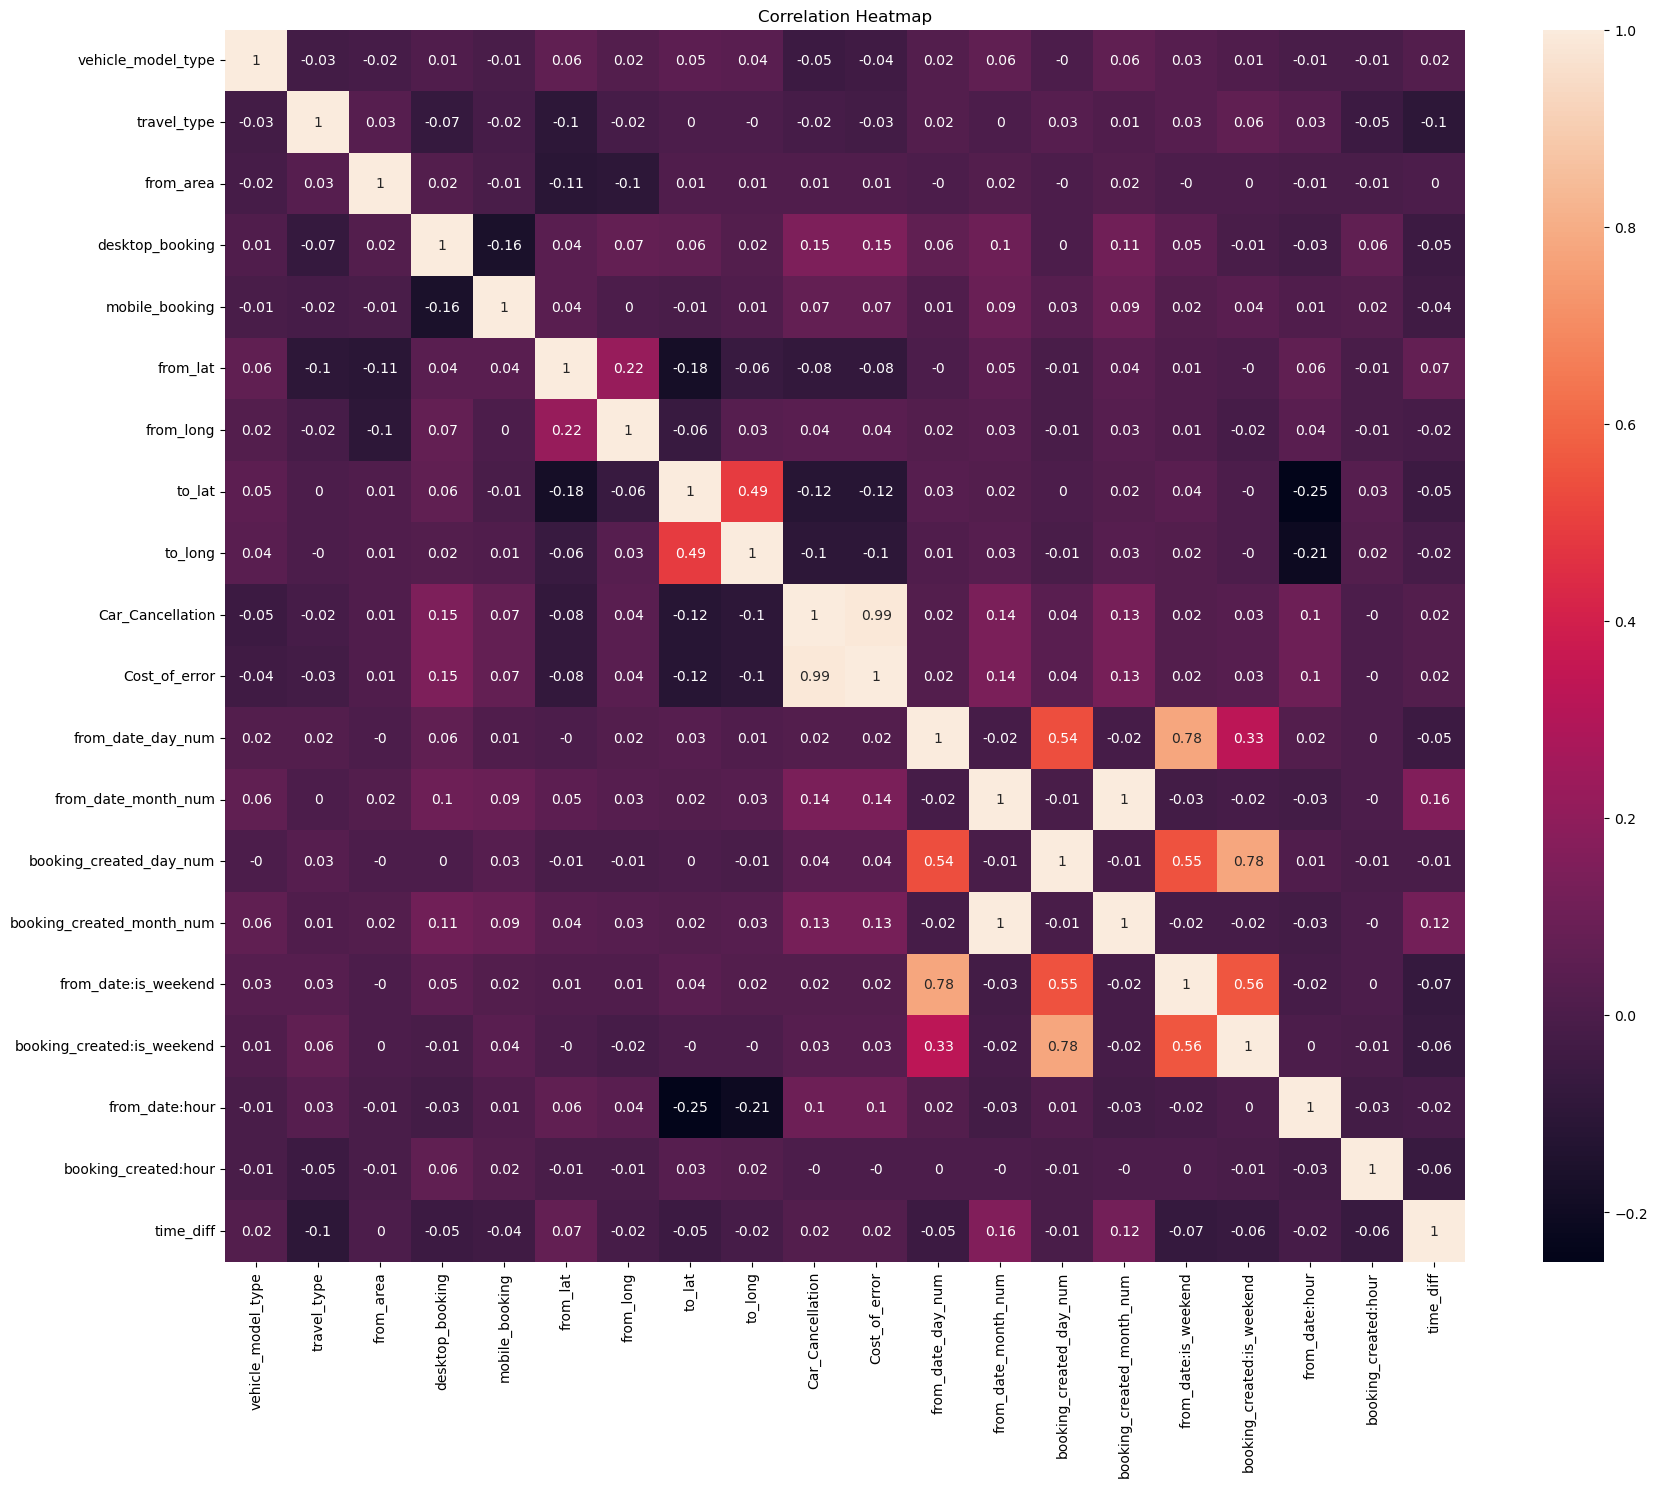

In [25]:
# Correlation Heatmap
fig, ax = plt.subplots(figsize=(20,16)) # Sample figsize in inches
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

**Visualization relationship between Cancellations and columns with data types 'object'**

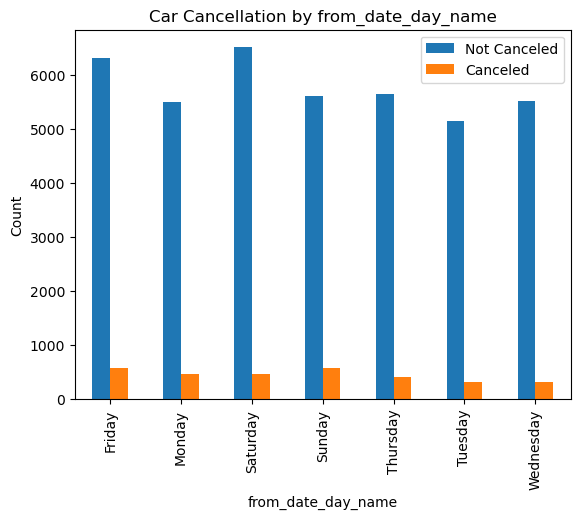

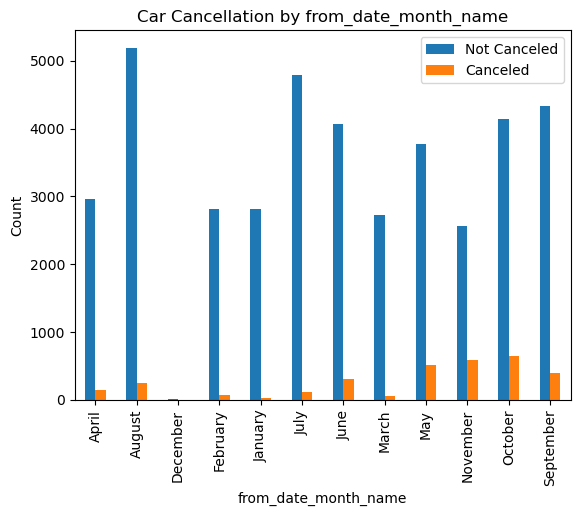

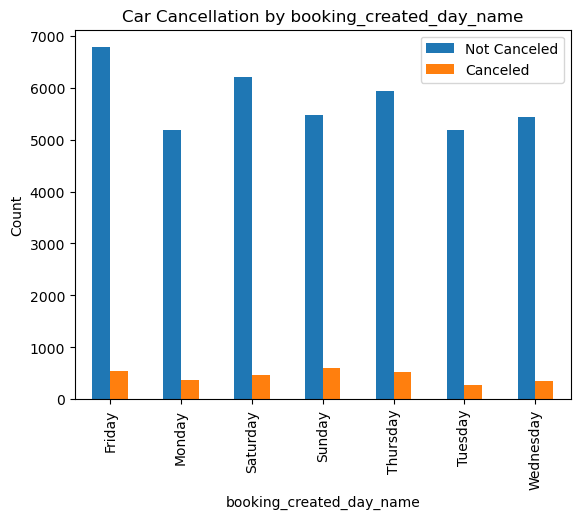

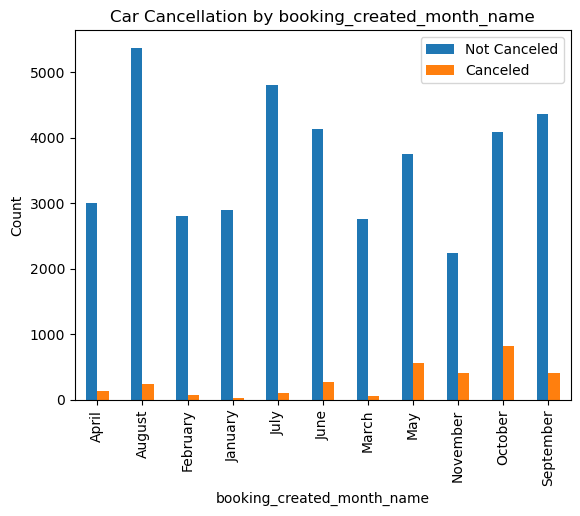

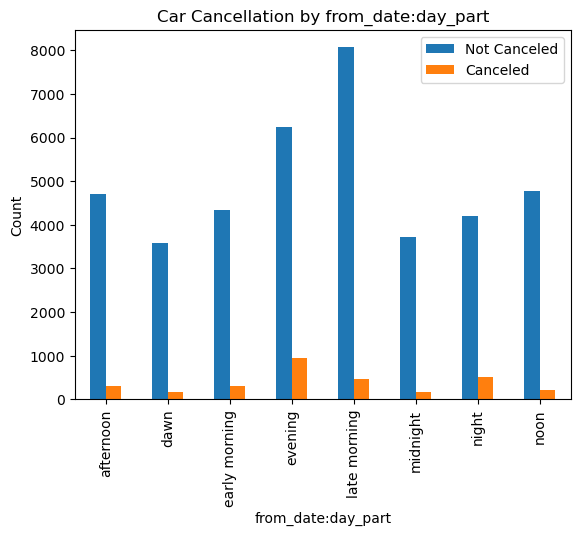

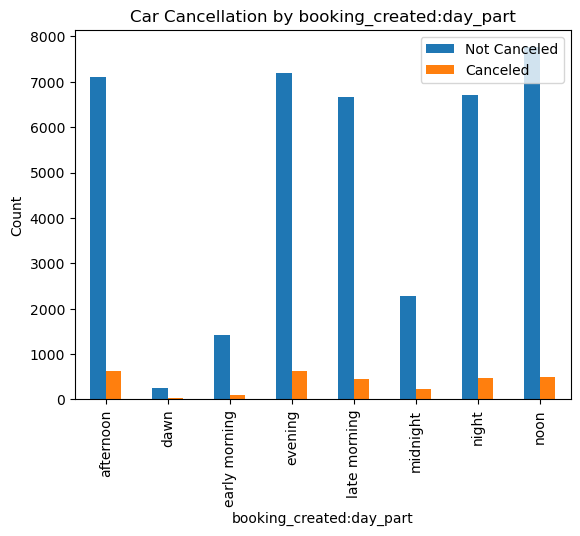

In [26]:
# Select object columns from the dataframe
object_columns = df.select_dtypes(include='object').columns

# Loop through each object column
for column in object_columns:
# Count the occurrences of car_cancellation for each category in the column
    cancellation_counts = df.groupby(column)['Car_Cancellation'].value_counts().unstack().fillna(0)

# Plot the bar chart
    cancellation_counts.plot(kind='bar', stacked=False)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Car Cancellation by {column}')
    plt.legend(['Not Canceled', 'Canceled'])
    plt.show()

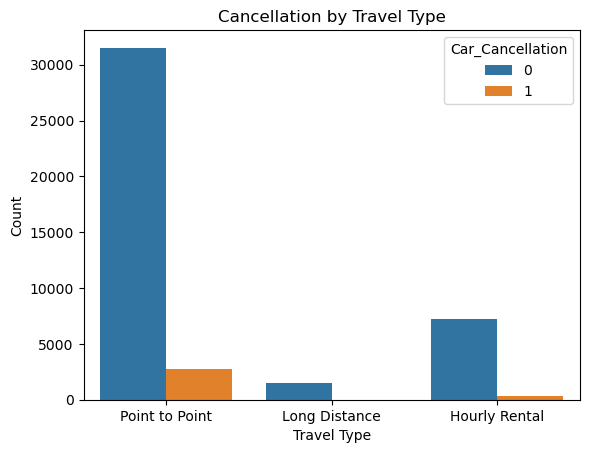

In [27]:
##Cancellations by Travel Type
# Create a dictionary mapping numeric values to categorical labels
travel_type_mapping = {1: 'Long Distance', 2: 'Point to Point', 3: 'Hourly Rental'}
df['travel_type'] = df['travel_type'].map(travel_type_mapping)
# Count the occurrences of each travel type
travel_type_counts = df['travel_type'].value_counts()

cancellation_counts = df.groupby('travel_type')['Car_Cancellation'].sum().reset_index()

# Plot the countplot
sns.countplot(data=df, x='travel_type', hue='Car_Cancellation')

# Set labels and title
plt.xlabel('Travel Type')
plt.ylabel('Count')
plt.title('Cancellation by Travel Type')

# Display the plot
plt.show()

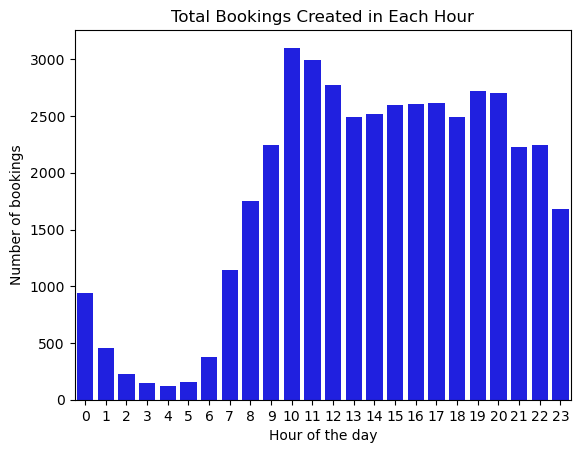

In [28]:
#total requests that come in for every hour in the day
#Group by the hour and calculate the count of bookings
hourly_counts = df.groupby('booking_created:hour').size()

# Create the plot using seaborn
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='blue')

# Set labels and title
plt.xlabel('Hour of the day')
plt.ylabel('Number of bookings')
plt.title('Total Bookings Created in Each Hour')

# Display the plot
plt.show()

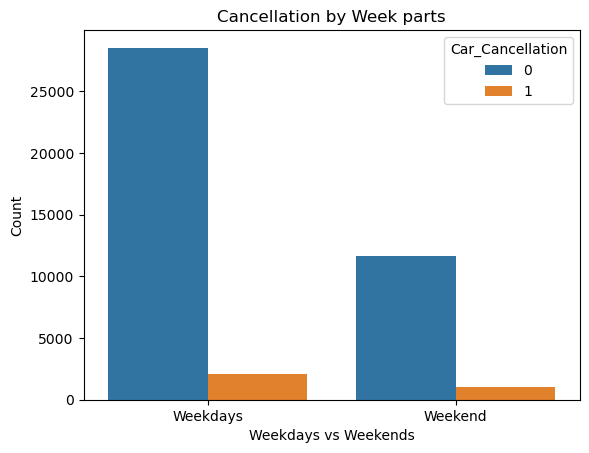

In [29]:
##Weekdays and Weekend Cancellations
# Create a dictionary mapping numeric values to categorical labels
booking_week = {0: 'Weekdays', 1: 'Weekend'}
df['booking_created:is_weekend'] = df['booking_created:is_weekend'].map(booking_week)

cancellation_week_count = df.groupby('booking_created:is_weekend')['Car_Cancellation'].sum().reset_index()
# Plot the countplot
sns.countplot(data=df, x='booking_created:is_weekend', hue='Car_Cancellation')

# Set labels and title
plt.xlabel('Weekdays vs Weekends')
plt.ylabel('Count')
plt.title('Cancellation by Week parts')

# Display the plot
plt.show()

In [ ]:
# Group by booking source and calculate the number of cancellations
booksource_grouped = df.groupby(['mobile_booking', 'desktop_booking'])['Car_Cancellation'].sum()

# Convert the grouped data to a DataFrame for plotting
grouped_df = booksource_grouped.reset_index()

# Create the plot
plt.figure(figsize=(8, 6))
plt.bar(grouped_df.index, grouped_df['cancellation'])
plt.xlabel('Booking Source')
plt.ylabel('Number of Cancellations')
plt.xticks(grouped_df.index, ['Mobile', 'Desktop'])
plt.title('Number of Cancellations by Booking Source')
plt.show()

# Data Division and Encoding Categories Variables

In [30]:
num = df.select_dtypes(include='number')
char = df.select_dtypes(include='object')

In [31]:
ml_df = df.copy()
ml_df

,vehicle_model_type,travel_type,from_area,desktop_booking,mobile_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,...,booking_created_day_num,booking_created_month_name,booking_created_month_num,from_date:is_weekend,booking_created:is_weekend,from_date:hour,from_date:day_part,booking_created:hour,booking_created:day_part,time_diff
0,28,Point to Point,83.0,0,0,12.924150,77.672290,12.927320,77.635750,0,...,1,January,1,0,Weekdays,2,midnight,1,midnight,21.0
1,12,Point to Point,1010.0,0,0,12.966910,77.749350,12.927680,77.626640,0,...,1,January,1,0,Weekdays,9,late morning,2,midnight,395.0
2,12,Point to Point,1301.0,0,0,12.937222,77.626915,13.047926,77.597766,0,...,1,January,1,0,Weekdays,3,midnight,3,midnight,22.0
3,12,Point to Point,768.0,0,0,12.989990,77.553320,12.971430,77.639140,0,...,1,January,1,0,Weekdays,5,dawn,4,dawn,66.0
4,12,Point to Point,1365.0,0,0,12.845653,77.677925,12.954340,77.600720,0,...,1,January,1,0,Weekdays,9,late morning,7,early morning,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43426,12,Point to Point,1147.0,1,0,13.030640,77.649100,12.952780,77.590880,0,...,6,November,11,1,Weekend,18,evening,14,afternoon,215.0
43427,12,Point to Point,393.0,1,0,13.199560,77.706880,13.017436,77.644580,0,...,6,November,11,0,Weekend,1,midnight,14,afternoon,2070.0
43428,12,Hourly Rental,974.0,0,0,13.075570,77.559040,13.026648,77.640595,0,...,6,November,11,1,Weekend,18,evening,14,afternoon,235.0
43429,87,Point to Point,1263.0,0,0,12.968970,77.594560,12.938230,77.622890,0,...,6,November,11,1,Weekend,16,afternoon,14,afternoon,77.0


In [32]:
#Encoding
traveltype = pd.get_dummies(ml_df['travel_type'],drop_first=True)
ml_df = pd.concat([ml_df,traveltype],axis=1)
ml_df = ml_df.drop(['travel_type'],axis=1)
ml_df.rename(columns={2:'traveltype_pointtopoint',3:'traveltype_hourly'},inplace=True)
ml_df

,vehicle_model_type,from_area,desktop_booking,mobile_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error,...,booking_created_month_num,from_date:is_weekend,booking_created:is_weekend,from_date:hour,from_date:day_part,booking_created:hour,booking_created:day_part,time_diff,Long Distance,Point to Point
0,28,83.0,0,0,12.924150,77.672290,12.927320,77.635750,0,1.0,...,1,0,Weekdays,2,midnight,1,midnight,21.0,0,1
1,12,1010.0,0,0,12.966910,77.749350,12.927680,77.626640,0,1.0,...,1,0,Weekdays,9,late morning,2,midnight,395.0,0,1
2,12,1301.0,0,0,12.937222,77.626915,13.047926,77.597766,0,1.0,...,1,0,Weekdays,3,midnight,3,midnight,22.0,0,1
3,12,768.0,0,0,12.989990,77.553320,12.971430,77.639140,0,1.0,...,1,0,Weekdays,5,dawn,4,dawn,66.0,0,1
4,12,1365.0,0,0,12.845653,77.677925,12.954340,77.600720,0,1.0,...,1,0,Weekdays,9,late morning,7,early morning,67.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43426,12,1147.0,1,0,13.030640,77.649100,12.952780,77.590880,0,1.0,...,11,1,Weekend,18,evening,14,afternoon,215.0,0,1
43427,12,393.0,1,0,13.199560,77.706880,13.017436,77.644580,0,1.0,...,11,0,Weekend,1,midnight,14,afternoon,2070.0,0,1
43428,12,974.0,0,0,13.075570,77.559040,13.026648,77.640595,0,1.0,...,11,1,Weekend,18,evening,14,afternoon,235.0,0,0
43429,87,1263.0,0,0,12.968970,77.594560,12.938230,77.622890,0,1.0,...,11,1,Weekend,16,afternoon,14,afternoon,77.0,0,1


In [33]:
# generate numeric values from categorical columns
ml_df = pd.get_dummies(char, drop_first = True) # dropping the first category

print(ml_df.shape)
ml_df


(43338, 50)


,travel_type_Long Distance,travel_type_Point to Point,from_date_day_name_Monday,from_date_day_name_Saturday,from_date_day_name_Sunday,from_date_day_name_Thursday,from_date_day_name_Tuesday,from_date_day_name_Wednesday,from_date_month_name_August,from_date_month_name_December,...,from_date:day_part_midnight,from_date:day_part_night,from_date:day_part_noon,booking_created:day_part_dawn,booking_created:day_part_early morning,booking_created:day_part_evening,booking_created:day_part_late morning,booking_created:day_part_midnight,booking_created:day_part_night,booking_created:day_part_noon
0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43426,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43427,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
43428,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43429,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#Concate numeric and categorical variables
ml_df = pd.concat([num,ml_df],axis=1,join='inner')
ml_df

,vehicle_model_type,from_area,desktop_booking,mobile_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error,...,from_date:day_part_midnight,from_date:day_part_night,from_date:day_part_noon,booking_created:day_part_dawn,booking_created:day_part_early morning,booking_created:day_part_evening,booking_created:day_part_late morning,booking_created:day_part_midnight,booking_created:day_part_night,booking_created:day_part_noon
0,28,83.0,0,0,12.924150,77.672290,12.927320,77.635750,0,1.0,...,1,0,0,0,0,0,0,1,0,0
1,12,1010.0,0,0,12.966910,77.749350,12.927680,77.626640,0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,12,1301.0,0,0,12.937222,77.626915,13.047926,77.597766,0,1.0,...,1,0,0,0,0,0,0,1,0,0
3,12,768.0,0,0,12.989990,77.553320,12.971430,77.639140,0,1.0,...,0,0,0,1,0,0,0,0,0,0
4,12,1365.0,0,0,12.845653,77.677925,12.954340,77.600720,0,1.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43426,12,1147.0,1,0,13.030640,77.649100,12.952780,77.590880,0,1.0,...,0,0,0,0,0,0,0,0,0,0
43427,12,393.0,1,0,13.199560,77.706880,13.017436,77.644580,0,1.0,...,1,0,0,0,0,0,0,0,0,0
43428,12,974.0,0,0,13.075570,77.559040,13.026648,77.640595,0,1.0,...,0,0,0,0,0,0,0,0,0,0
43429,87,1263.0,0,0,12.968970,77.594560,12.938230,77.622890,0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43338 entries, 0 to 43430
Data columns (total 68 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   vehicle_model_type                      43338 non-null  int64  
 1   from_area                               43338 non-null  float64
 2   desktop_booking                         43338 non-null  int64  
 3   mobile_booking                          43338 non-null  int64  
 4   from_lat                                43338 non-null  float64
 5   from_long                               43338 non-null  float64
 6   to_lat                                  43338 non-null  float64
 7   to_long                                 43338 non-null  float64
 8   Car_Cancellation                        43338 non-null  int64  
 9   Cost_of_error                           43338 non-null  float64
 10  from_date_day_num                       43338 non-null  in

In [36]:
# target and predictors
predictors = ml_df.drop(['vehicle_model_type', 'from_area','from_lat', 'from_long', 'to_lat', 'to_long', 'from_date_day_num', 'from_date_month_num','Car_Cancellation', 'Cost_of_error','booking_created_day_num','booking_created_month_num'], axis = 1)
target = ml_df[['Car_Cancellation']]

predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43338 entries, 0 to 43430
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   desktop_booking                         43338 non-null  int64  
 1   mobile_booking                          43338 non-null  int64  
 2   from_date:is_weekend                    43338 non-null  int64  
 3   from_date:hour                          43338 non-null  int64  
 4   booking_created:hour                    43338 non-null  int64  
 5   time_diff                               43338 non-null  float64
 6   travel_type_Long Distance               43338 non-null  uint8  
 7   travel_type_Point to Point              43338 non-null  uint8  
 8   from_date_day_name_Monday               43338 non-null  uint8  
 9   from_date_day_name_Saturday             43338 non-null  uint8  
 10  from_date_day_name_Sunday               43338 non-null  ui

# Build Machine Learning - Neural Network

In [39]:
X = predictors
y = target
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)

In [40]:
clf = MLPClassifier(hidden_layer_sizes=(3), activation='logistic', solver='lbfgs',random_state=1)
clf.fit(train_X, train_y)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', hidden_layer_sizes=3, random_state=1,
              solver='lbfgs')

In [42]:
# Network structure
print('Intercepts')
print(clf.intercepts_)
print('Weights')
print(clf.coefs_)

Intercepts
[array([1.0407515 , 1.12245564, 0.1982206 ]), array([1.37643551])]
Weights
[array([[-2.03199094e+00, -1.64064109e+00, -1.49560381e-01],
       [-1.57112121e+00, -5.62512797e-01, -1.47162911e-01],
       [ 2.75230744e-02,  3.61358259e-01,  4.17052937e-02],
       [-2.24406684e-02,  1.42932683e+00,  2.24296949e+00],
       [ 5.79147013e-02, -1.19565739e+00,  2.55160993e+00],
       [ 2.14193770e-03, -1.19293109e-01, -3.20399561e-03],
       [ 9.02370759e-02, -5.07928378e-02,  1.24366784e-01],
       [-8.11115852e-01, -1.56578258e-01,  2.78391961e-01],
       [ 2.23666870e-01,  3.72374311e-01, -1.28971828e-01],
       [ 2.20484513e-02,  8.92143013e-02,  1.92236607e-01],
       [-1.96617281e-01,  1.78390879e-01,  1.95309610e-01],
       [ 3.37110141e-01,  3.11965424e-01, -2.57691883e-02],
       [ 2.45562703e-01,  2.09191410e-01, -1.69314568e-01],
       [ 3.71730686e-01,  3.89146763e-01,  1.47635381e-01],
       [ 7.05693667e-02,  9.63967195e-02, -1.07715933e-01],
       [-1.91

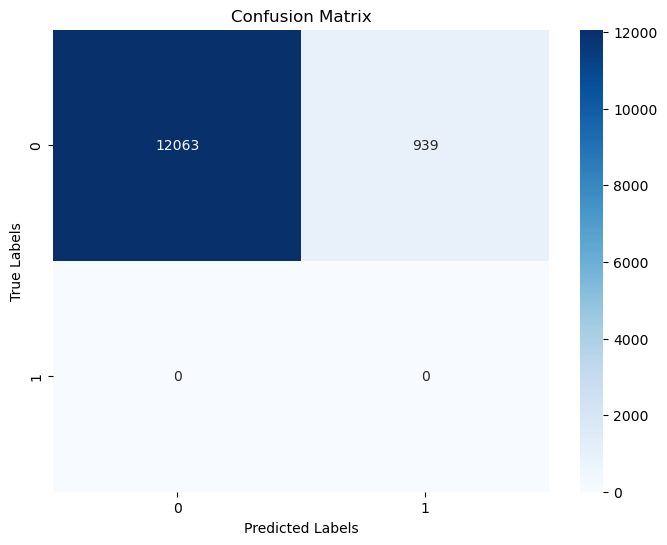

Accuracy: 0.9277803414859253


In [41]:
#Predicting y for X_test
y_pred = clf.predict(valid_X)

# validation performance
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, valid_y)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

from sklearn.metrics import accuracy_score
# Calculate accuracy score
accuracy = accuracy_score(valid_y, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

# Build Machine Learning - K-Nearest Neighbors (KNN) 

In [45]:
knn = KNeighborsClassifier(weights='distance', n_neighbors=10)
knn.fit(train_X, train_y)

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10, weights='distance')

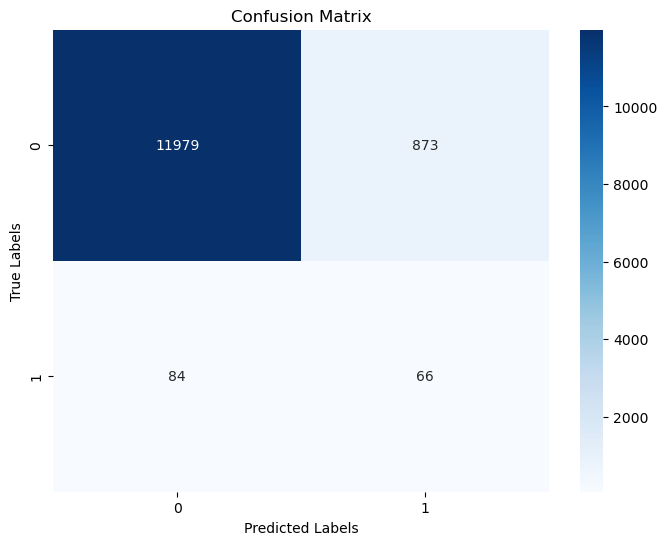

Accuracy: 0.9263959390862944


In [46]:
y_pred2 = knn.predict(valid_X)

# validation performance
cm = confusion_matrix(y_pred2, valid_y)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate accuracy score
accuracy = accuracy_score(valid_y, y_pred2)

# Print the accuracy score
print("Accuracy:", accuracy)
